# AB Testing Cookie Cats

Pada notebook ini, kita akan mencoba menganalisis menggunakan A/B test, dari memformulasikan hipotesis, mengujinya, dan mengintepretasikan hasilnya. Data yang digunakan <a href='https://www.kaggle.com/datasets/yufengsui/mobile-games-ab-testing'>dataset dari Kaggle</a> yang berisi A/B test dari Game Cookie Cats.  

Dalam game ini, saat pemain maju melalui beberapa leveln, mereka kadang-kadang akan menemukan gerbang yang memaksa mereka untuk menunggu dalam waktu yang tidak terlalu lama atau melakukan pembelian dalam aplikasi. Selain mendorong pembelian dalam aplikasi, gerbang ini memiliki tujuan penting, yaitu memberi waktu bagi pemain untuk istirahat sehingga diharapkan dapat meningkatkan dan memperpanjang kesenangan pemain terhadap game.

Tapi dimana gerbang harus ditempatkan? Awalnya gerbang pertama ditempatkan di level 30. Tetapi di notebook ini, kita akan menganalisis A/B test di mana kita memindahkan gerbang pertama di Cookie Cats dari level 30 ke level 40. Secara khusus, kita akan melihat dampaknya pada retensi pemain.

Hal yang akan kita lakukan sebagai berikut:
1. Desain eksperimen
2. Mengumpulkan dan mempersiapkan data
3. Visualisasi Data
4. Uji Hipotesis
5. Menarik kesimpulan


***
## 1. Desain Eksperimen

### Formulasi Hipotesis


Hal pertama, kita ingin memastikan bahwa kita perlu merumuskan hipotesis di awal proyek. Proses ini akan memastikan interpretasi kita terhadap hasilnya benar dan tepat.

Tugas yang diberikan kita untuk mengetahui apakah desain baru memiliki performa yang lebih baik, lebih buruk, atau sama. Untuk itu, kita akan memilih <a href="https://en.wikipedia.org/wiki/One-_and_two-tailed_tests">**two-tailed test**</a>:

$$H_0: p = p_0$$
$$H_a: p \ne p_0$$

dimana $p$ dan $p_0$ secara berturut-turut berarti conversion rate dari the new and old design. Kita juga mengatur confidence level sebesar 95%:

$$\alpha = 0.05$$

Nilai $\alpha$ adalah ambang batas yang kita atur, yang berarti "jika probabilitas dari hasil yang diobservasi ($p$-value) kurang dari $\alpha$, maka null hypothesis ditolak". Karena nilai yang diatur $\alpha=0.05$, tingkat keyakinan kita (1 - $\alpha$) adalah 95%.

### Memilih Variabel

Pada pengujian yang dilakukan, kita membutuhkan 2 grup:
* Grup kontrol - Gerbang pada level 30
* Grup perlakuan - Gerbang pada level 40

Ini merupakan variabel independen pada pengujian ini. Variabel lain selain level gerbang pada game dijaga agar tetap sama. Hal ini dikarenakan kita ingin langsung membandingkan antara dua grup yang berbeda. Apabila variabel lain tidak dijaga tetap sama, maka kita tidak dapat memastikan variabel mana yang mempengaruhi retention rate pengguna.

Variabel terikat pada pengujian ini adalah retention rate, yang dilambangkan sebagai berikut:
* `0` - Pengguna tidak kembali bermain
* `1` - Pengguna kembali bermain

In [1]:
# Import package
import numpy as np
import pandas as pd
import scipy.stats as stats
import statsmodels.stats.api as sms
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil

%matplotlib inline

# Some plot styling preferences
plt.style.use('seaborn-whitegrid')
font = {'family' : 'Helvetica',
        'weight' : 'bold',
        'size'   : 14}

mpl.rc('font', **font)

C:\Users\kana\Anaconda3\envs\tensorflow_env\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\kana\Anaconda3\envs\tensorflow_env\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
C:\Users\kana\Anaconda3\envs\tensorflow_env\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  stacklevel=1)


***
## 2. Mengumpulkan dan Mempersiapkan Data

Data yang dikumpulkan pada analisis ini menggunakan dataset online sebagai simulasi:
1. Download data dari <a href='https://www.kaggle.com/datasets/yufengsui/mobile-games-ab-testing'>Kaggle</a>
2. Baca data menggunakan dataframe
3. Cek dan bersihkan data jika diperlukan

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/wandakinasih/gg2/main/cookie_cats.csv')

df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


Kita punya data dari 90.189 players yang menginstal game ketika AB-test dijalankan. Variabelnya yaitu:

* `userid` - nomor unik bagi setiap player.
* `version` - Versi dari game, variabel yang diuji pada AB test kali ini
* `sum_gamerounds` - Jumlah ronde game yang dimainkan player dalam 14 hari pertama setelah instalasi
* `retention_1` - Apakah player kembali bermain setelah 1 hari menginstal?
* `retention_7` - Apakah player kembali bermain setelah 2 hari menginstal?

In [4]:
session_counts = df['userid'].value_counts(ascending=False)
multi_users = session_counts[session_counts > 1].count()

print(f'Terdapat {multi_users} pengguna yang muncul beberapa kali')

Terdapat 0 pengguna yang muncul beberapa kali


In [6]:
print(f'Jumlah player yang memainkan (unik) sebanyak {df["userid"].nunique()} player')

Jumlah player yang memainkan (unik) sebanyak 90189 player


In [7]:
# Counting the number of players in each A/B group.
df.groupby("version")[["userid"]].nunique()

,userid
version,
gate_30,44700
gate_40,45489


***
## 3. Visualisasi Hasil

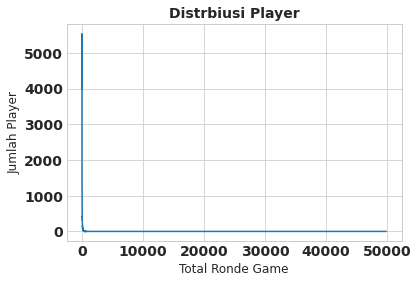

In [10]:
 # Distribusi Ronde Game
plot_df = df.groupby("sum_gamerounds")["userid"].count()

ax = plot_df.plot()
plt.title("Distrbiusi Player", fontweight="bold", size=14)
plt.xlabel("Total Ronde Game", size=12)
plt.ylabel("Jumlah Player", size=12)
plt.show()

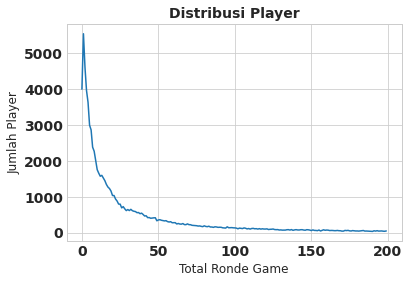

In [12]:
 # Distribusi Ronde Game
plot_df = df.groupby("sum_gamerounds")["userid"].count()

ax = plot_df.head(200).plot()
plt.title("Distribusi Player", fontweight="bold", size=14)
plt.xlabel("Total Ronde Game", size=12)
plt.ylabel("Jumlah Player", size=12)
plt.show()

Terdapat beberapa player yang tidak memainkan sama sekali setelah menginstal (0 ronde)

In [18]:
print(f'Jumlah player yang tidak memainkan sama sekali sebanyak {df[df["sum_gamerounds"]== 0]["userid"].count()} player') 
print(f'Angka ini sebanyak {round(df[df["sum_gamerounds"]== 0]["userid"].count()/df.shape[0]*100, 2)}%')

Jumlah player yang tidak memainkan sama sekali sebanyak 3994 player
Angka ini sebanyak 4.43%


In [19]:
df_retention_ab = df.groupby("version").agg({"userid":"count", "retention_1":"mean","retention_7":"mean", "sum_gamerounds":"mean"})
df_retention_ab

,userid,retention_1,retention_7,sum_gamerounds
version,,,,
gate_30,44700,0.448188,0.190201,52.456264
gate_40,45489,0.442283,0.182000,51.298776


In [23]:
conversion_rates = df.groupby('version')['retention_1', 'retention_7']

std_p = lambda x: np.std(x, ddof=0)              # Std. deviation of the proportion
se_p = lambda x: stats.sem(x, ddof=0)            # Std. error of the proportion (std / sqrt(n))

conversion_rates = conversion_rates.agg([np.mean, std_p, se_p])
conversion_rates.columns = ['retention_rate_1', 'std_deviation_1', 'std_error_1', 'retention_rate_7', 'std_deviation_7', 'std_error_7']


conversion_rates.style.format('{:.3f}')

C:\Users\kana\Anaconda3\envs\tensorflow_env\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


,retention_rate_1,std_deviation_1,std_error_1,retention_rate_7,std_deviation_7,std_error_7
version,,,,,,
gate_30,0.448,0.497,0.002,0.190,0.392,0.002
gate_40,0.442,0.497,0.002,0.182,0.386,0.002


Berdasarkan statistik, hasil pengujian menunjukkan adanya kemiripan antara gerbang 30 dan 40, baik pada retention rate 1 maupun 7. Terlebih lagi justru retention rate gate 40 lebih rendah dibandingkan gate 30.



Text(0, 0.5, 'Retention Rate')

<Figure size 576x432 with 0 Axes>

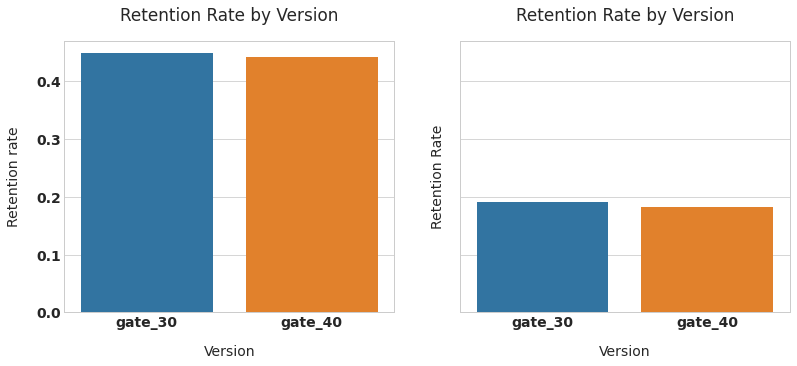

In [32]:
plt.figure(figsize=(8,6))

fig, (ax1,ax2) = plt.subplots(1, 2, sharey=True, figsize=(13,5))

sns.barplot(x=df['version'], y=df['retention_1'], ci=False, ax=ax1)
ax1.set_title('Retention Rate by Version', pad=20)
ax1.set_xlabel('Version', labelpad=15)
ax1.set_ylabel('Retention rate', labelpad=15)

sns.barplot(x=df['version'], y=df['retention_7'], ci=False, ax=ax2)
ax2.set_title('Retention Rate by Version', pad=20)
ax2.set_xlabel('Version', labelpad=15)
ax2.set_ylabel('Retention Rate', labelpad=15)

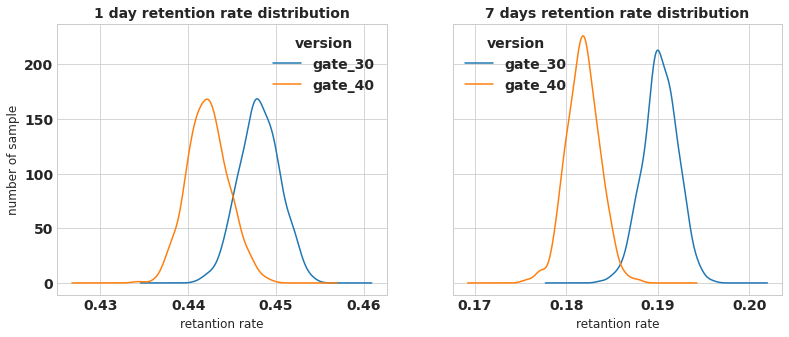

In [35]:
# Creating an list with bootstrapped means for each A/B group
boot_1d = []
boot_7d = []
for i in range(500):
    boot_mean_1 = df.sample(frac=1, replace=True).groupby('version')['retention_1'].mean()
    boot_mean_7 = df.sample(frac=1, replace=True).groupby('version')['retention_7'].mean()
    boot_1d.append(boot_mean_1)
    boot_7d.append(boot_mean_7)
    
# Transforming the list to a DataFrame
boot_1d = pd.DataFrame(boot_1d)
boot_7d = pd.DataFrame(boot_7d)

# Kernel Density Estimate plot of the bootstrap distributions
fig, (ax1,ax2) = plt.subplots(1, 2, sharey=True, figsize=(13,5))

boot_1d.plot.kde(ax=ax1)
ax1.set_xlabel("retantion rate",size=12)
ax1.set_ylabel("number of sample",size=12)
ax1.set_title("1 day retention rate distribution", fontweight="bold",size=14)

boot_7d.plot.kde(ax=ax2)
ax2.set_xlabel("retantion rate",size=12)
ax2.set_title("7 days retention rate distribution", fontweight="bold",size=14)
plt.show()

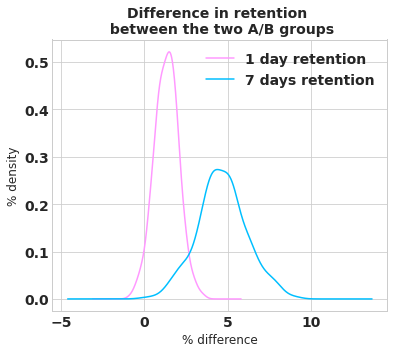

In [36]:
# Adding a column with the % difference between the two A/B groups
boot_1d['diff'] = ((boot_1d['gate_30'] - boot_1d['gate_40']) / boot_1d['gate_40'] * 100)
boot_7d['diff'] = ((boot_7d['gate_30'] - boot_7d['gate_40']) / boot_7d['gate_40'] * 100)

# Ploting the bootstrap % difference
fig, (ax1) = plt.subplots(1, 1,figsize=(6,5))

boot_1d['diff'].plot.kde(ax=ax1, c="#ff99ff", label = "1 day retention")
boot_7d['diff'].plot.kde(ax=ax1, c= "#00bfff", label = "7 days retention")
ax1.set_xlabel("% difference",size=12)
ax1.set_ylabel("% density",size=12)
ax1.set_title("Difference in retention \n between the two A/B groups", fontweight="bold", size=14)
plt.legend()
plt.show()

***
## 4. Uji hipotesis

In [39]:
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

In [40]:
control_results_1 = df[df['version'] == 'gate_30']['retention_1']
treatment_results_1 = df[df['version'] == 'gate_40']['retention_1']
control_results_7 = df[df['version'] == 'gate_30']['retention_7']
treatment_results_7 = df[df['version'] == 'gate_40']['retention_7']

In [41]:
n_con = control_results_1.count()
n_treat = treatment_results_1.count()
successes = [control_results_1.sum(), treatment_results_1.sum()]
nobs = [n_con, n_treat]

z_stat, pval = proportions_ztest(successes, nobs=nobs)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)

print(f'z statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'ci 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'ci 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

z statistic: 1.78
p-value: 0.074
ci 95% for control group: [0.444, 0.453]
ci 95% for treatment group: [0.438, 0.447]


In [42]:
n_con = control_results_7.count()
n_treat = treatment_results_7.count()
successes = [control_results_7.sum(), treatment_results_7.sum()]
nobs = [n_con, n_treat]

z_stat, pval = proportions_ztest(successes, nobs=nobs)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)

print(f'z statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'ci 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'ci 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

z statistic: 3.16
p-value: 0.002
ci 95% for control group: [0.187, 0.194]
ci 95% for treatment group: [0.178, 0.186]


***
## 5. Menarik Kesimpulan

Karena nilai $p$-value=0.164 yang mana lebih tinggi sedikit dari nilai $\alpha$=0.05, kita tidak dapat menolak null hipotesis $H_0$, yang artinya desain baru tidak menunjukkan kinerja yang berbeda secara signifikan dengan desain lama. Atau dari angka yang didapat, perbedaan nilai 1,4% bernilai kurang signifikan.

Akan tetapi, nilai yang didapat menunjukkan bahwa adanya kemungkinan desain baru bekerja dengan baik karena desain baru memiliki interval conversion rate (0,113 - 0,143) yang berarti:
1. Itu tidak masuk dalam baseline 11%
2. Itu masuk dalam target conversion rate 14%

Oleh karena itu, desain baru masih bisa dipertimbangkan lebih lanjut karena hanya sedikit tidak signifikan.